In [16]:
!ls

ls: cannot access '/data': No such file or directory


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [4]:
cd 'gdrive/My Drive/523'

/content/gdrive/My Drive/523


Import Statements

In [0]:
import numpy as np
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from tqdm import tqdm
from os import sys, path 
import pandas as pd

# Imputation using GAIN 

Created a wrapper around the GAIN implementation by the 

Authors: Jinsung Yoon, James Jordon, Mihaela van der Schaar
Paper: Jinsung Yoon, James Jordon, Mihaela van der Schaar, "GAIN: Missing Data Imputation using Generative Adversarial Nets," International Conference on Machine Learning (ICML), 2018.
Paper Link: http://proceedings.mlr.press/v80/yoon18a/yoon18a.pdf
https://github.com/jsyoon0823/GAIN

Initialization for mini batch size, missing rate, hint rate, alpha and train rate

In [0]:

class GAIN():
    # defining hyperparameters 
    def __init__(self, minibatch_size, missing_vals_percent, p_hint, alpha, train_rate):
        self.mb_size= minibatch_size
        self.p_miss = missing_vals_percent
        self.p_hint = p_hint
        self.alpha = alpha
        self.train_rate = train_rate
        self.H_Dim1 = None
        self.H_Dim2 = None
        print('Initialised GAIN object')

Functions for normalize, missingness introduction, train test split

In [0]:
class GAIN(GAIN):
    def normalize(self, data, dimension):
            Min_Val = np.zeros(dimension)
            Max_Val = np.zeros(dimension)
            for i in range(dimension):
                Min_Val[i] = np.min(data[:,i])
                data[:,i] = data[:,i] - np.min(data[:,i])
                Max_Val[i] = np.max(data[:,i])
                data[:,i] = data[:,i] / (np.max(data[:,i]) + 1e-6)  
            print('Norm Done')              
            return data   
    
    def introduce_missingness(self, Dim, No, Data):
            p_miss_vec = self.p_miss * np.ones((Dim,1))
            Missing = np.zeros((No, Dim))
            for i in range(Dim):
                A = np.random.uniform(0., 1., size = [len(Data),])
                B = A > p_miss_vec[i]
                Missing[:,i] = 1.*B
            print('Missing Done')
            return Missing
    
    def train_test_split(self, No, Data, Missing):
        idx = np.random.permutation(No)
        Train_No = int(No * self.train_rate)
        Test_No = No - Train_No
        trainX = Data[idx[:Train_No],:]
        testX = Data[idx[Train_No:],:]
        trainM = Missing[idx[:Train_No],:]
        testM = Missing[idx[Train_No:],:]
        print('Train/Test Done')
        return trainX, testX, trainM, testM, Train_No, Test_No

Implementing gain architecture, generator, discriminator

In [0]:
class GAIN(GAIN):
    def gain_architecture(self, Dim):
            X = tf.placeholder(tf.float32, shape = [None, Dim])
            M = tf.placeholder(tf.float32, shape = [None, Dim])
            H = tf.placeholder(tf.float32, shape = [None, Dim])
            New_X = tf.placeholder(tf.float32, shape = [None, Dim])
            D_W1 = tf.Variable(self.xavier_init([Dim*2, self.H_Dim1]))     # Data + Hint as inputs
            D_b1 = tf.Variable(tf.zeros(shape = [ self.H_Dim1]))
            D_W2 = tf.Variable(self.xavier_init([self.H_Dim1, self.H_Dim2]))
            D_b2 = tf.Variable(tf.zeros(shape = [self.H_Dim2]))
            D_W3 = tf.Variable(self.xavier_init([self.H_Dim2, Dim]))
            D_b3 = tf.Variable(tf.zeros(shape = [Dim]))       # Output is multi-variate
            theta_D = [D_W1, D_W2, D_W3, D_b1, D_b2, D_b3]
            G_W1 = tf.Variable(self.xavier_init([Dim*2, self.H_Dim1]))     # Data + Mask as inputs (Random Noises are in Missing Components)
            G_b1 = tf.Variable(tf.zeros(shape = [self.H_Dim1]))
            G_W2 = tf.Variable(self.xavier_init([self.H_Dim1, self.H_Dim2]))
            G_b2 = tf.Variable(tf.zeros(shape = [self.H_Dim2]))
            G_W3 = tf.Variable(self.xavier_init([self.H_Dim2, Dim]))
            G_b3 = tf.Variable(tf.zeros(shape = [Dim]))
            theta_G = [G_W1, G_W2, G_W3, G_b1, G_b2, G_b3]
            print('Gain Arch Done')
            return theta_D, theta_G, X, M, H, New_X
    @staticmethod
    def generator(new_x, m, G_W1, G_W2, G_W3, G_b1, G_b2, G_b3):
        inputs = tf.concat(axis = 1, values = [new_x,m])  # Mask + Data Concatenate
        G_h1 = tf.nn.relu(tf.matmul(inputs, G_W1) + G_b1)
        G_h2 = tf.nn.relu(tf.matmul(G_h1, G_W2) + G_b2)   
        G_prob = tf.nn.sigmoid(tf.matmul(G_h2, G_W3) + G_b3) # [0,1] normalized Output
        print('Gen Samp Done')
        return G_prob
            
    @staticmethod
    def discriminator(new_x, h, D_W1, D_W2, D_W3, D_b1, D_b2, D_b3):
        inputs = tf.concat(axis = 1, values = [new_x,h])  # Hint + Data Concatenate
        D_h1 = tf.nn.relu(tf.matmul(inputs, D_W1) + D_b1)  
        D_h2 = tf.nn.relu(tf.matmul(D_h1, D_W2) + D_b2)
        D_logit = tf.matmul(D_h2, D_W3) + D_b3
        D_prob = tf.nn.sigmoid(D_logit)  # [0,1] Probability Output
        print('Disc Sample Done')
        return D_prob

 Preprocessing input data : normalize, load, get dimensions

In [0]:
class GAIN(GAIN):
    def preprocess(self, inputData):
            Data = np.loadtxt(inputData, delimiter=",",skiprows=1)
            #Data = np.loadtxt(inputData, delimiter=",")
            No = len(Data)
            Dim = len(Data[0,:])
            self.H_Dim1 = Dim
            self.H_Dim2 = Dim
            normalized_data = self.normalize(Data, Dim)
            print('Preprocess Done')
            return normalized_data, No, Dim

Static methods: xavier initialization, sample generation 

In [0]:
class GAIN(GAIN):
    @staticmethod
    def xavier_init(size):
        in_dim = size[0]
        xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
        return tf.random_normal(shape = size, stddev = xavier_stddev)
    @staticmethod
    def sample_M(m, n, p):
        A = np.random.uniform(0., 1., size = [m, n])
        B = A > p
        C = 1.*B
        return C    
    @staticmethod
    def sample_Z(m, n):
        return np.random.uniform(0., 0.01, size = [m, n])    
    @staticmethod    
    def sample_idx(m, n):
         A = np.random.permutation(m)
         idx = A[:n]
         return idx

Train function

In [0]:

class GAIN(GAIN):    
    def train(self, normalized_data, No, Dim):
        missing_matrix  = self.introduce_missingness(Dim, No, normalized_data)
        trainX, testX, trainM, testM, Train_No, Test_No= self.train_test_split(No, normalized_data, missing_matrix)
        theta_D, theta_G, X, M, H, New_X = self.gain_architecture(Dim)
        G_sample = self.generator(New_X, M, theta_G[0],theta_G[1], theta_G[2], theta_G[3], theta_G[4], theta_G[5])
        Hat_New_X = New_X * M + G_sample * (1-M)
        D_prob = self.discriminator(Hat_New_X, H, theta_D[0], theta_D[1], theta_D[2], theta_D[3],theta_D[4],theta_D[5])
        D_loss1 = -tf.reduce_mean(M * tf.log(D_prob + 1e-8) + (1-M) * tf.log(1. - D_prob + 1e-8)) 
        G_loss1 = -tf.reduce_mean((1-M) * tf.log(D_prob + 1e-8))
        MSE_train_loss = tf.reduce_mean((M * New_X - M * G_sample)**2) / tf.reduce_mean(M)
        D_loss = D_loss1
        G_loss = G_loss1 + gain_obj.alpha * MSE_train_loss
        MSE_test_loss = tf.reduce_mean(((1-M) * X - (1-M)*G_sample)**2) / tf.reduce_mean(1-M)
        D_solver = tf.train.AdamOptimizer().minimize(D_loss, var_list=theta_D)
        G_solver = tf.train.AdamOptimizer().minimize(G_loss, var_list=theta_G)
        sess = tf.Session()
        sess.run(tf.global_variables_initializer())
        train_loss_1 = []
        test_loss_1 = []
        for it in tqdm(range(5000)):    
            mb_idx = gain_obj.sample_idx(Train_No, gain_obj.mb_size)
            X_mb = trainX[mb_idx,:]      
            Z_mb = gain_obj.sample_Z(gain_obj.mb_size, Dim) 
            M_mb = trainM[mb_idx,:]  
            H_mb1 = gain_obj.sample_M(gain_obj.mb_size, Dim, 1-gain_obj.p_hint)
            H_mb = M_mb * H_mb1    
            New_X_mb = M_mb * X_mb + (1-M_mb) * Z_mb  # Missing Data Introduce    
            _, D_loss_curr = sess.run([D_solver, D_loss1], feed_dict = {M: M_mb, New_X: New_X_mb, H: H_mb})
            _, G_loss_curr, MSE_train_loss_curr, MSE_test_loss_curr = sess.run([G_solver, G_loss1, MSE_train_loss, MSE_test_loss],
                                                                           feed_dict = {X: X_mb, M: M_mb, New_X: New_X_mb, H: H_mb})
            if it % 100 == 0:
                print('Iter: {}'.format(it))
                train_loss_1.append(np.sqrt(MSE_train_loss_curr))
                test_loss_1.append(np.sqrt(MSE_test_loss_curr))
                print('Train_loss: {:.4}'.format(np.sqrt(MSE_train_loss_curr)))
                print('Test_loss: {:.4}'.format(np.sqrt(MSE_test_loss_curr)))
                print()
        return Test_No, testM, testX, MSE_test_loss, G_sample, sess, X, M, New_X, train_loss_1, test_loss_1

Test functions, impute, evaluate. [Evaluate results are provided in test]

In [0]:
class GAIN(GAIN):
    def test(self, Test_No, testM, testX, MSE_test_loss, G_sample, sess, X, M, New_X):
        Z_mb = gain_obj.sample_Z(Test_No, Dim) 
        M_mb = testM
        X_mb = testX
        New_X_mb = M_mb * X_mb + (1-M_mb) * Z_mb  # Missing Data Introduce
        MSE_final, Sample = sess.run([MSE_test_loss, G_sample], feed_dict = {X: testX, M: testM, New_X: New_X_mb})
        print('Final Test RMSE: ' + str(np.sqrt(MSE_final)))
        
    def impute(self, trained_model, input):
        pass
    
    def evaluate(self, trained_model, input):
        pass

# Main function to access GAIN, initial params, and with dataset in .csv

## GAIN on Letter Dataset

In [0]:
df_1 = pd.read_csv('/content/gdrive/My Drive/523/data/letter.csv')

In [76]:
df_1.head()

,20,2,8,3,5,1,8.1,13,0,6,6.1,10,8.2,0.1,8.3,0.2,8.4
0,9,5,12,3,7,2,10,5,5,4,13,3,9,2,8,4,10
1,4,4,11,6,8,6,10,6,2,6,10,3,7,3,7,3,9
2,14,7,11,6,6,3,5,9,4,6,4,4,10,6,10,2,8
3,7,2,1,3,1,1,8,6,6,6,6,5,9,1,7,5,10
4,19,4,11,5,8,3,8,8,6,9,5,6,6,0,8,9,7


In [77]:
mini_batch_size = 128
percentage_missing_values = 0.2
hint_perc = 0.9
alpha = 10
train_rate = 0.8

gain_obj = GAIN(mini_batch_size,percentage_missing_values, hint_perc,alpha, train_rate)
normalized_data, No_rows, Dim_cols= gain_obj.preprocess('/content/gdrive/My Drive/523/data/letter.csv')

Initialised GAIN object
Norm Done
Preprocess Done


In [0]:
Test_No, testM, testX, MSE_test_loss, G_sample, sess, X, M, New_X, train_loss_1, test_loss_1 = gain_obj.train(normalized_data, No_rows, Dim_cols)


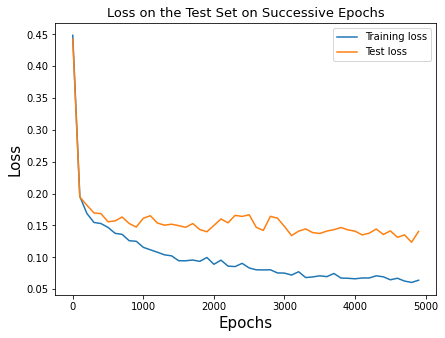

In [91]:
# plotting the training loss
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot( [i * 100 for i in range(len(train_loss_1))],train_loss_1, label='Training loss')
plt.title('Loss on the Training Set on Successive Epochs',size= 13)
plt.legend()
plt.xlabel('Epochs',size= 15)
plt.ylabel('Loss',size=15)


plt.plot([i * 100 for i in range(len(train_loss_1))],test_loss_1, label='Test loss')
plt.title('Loss on the Test Set on Successive Epochs',size= 13)
plt.legend()
plt.xlabel('Epochs',size= 15)
plt.ylabel('Loss',size=15)
plt.show()

In [92]:
New_X

<tf.Tensor 'Placeholder_23:0' shape=(?, 17) dtype=float32>

In [93]:
X

<tf.Tensor 'Placeholder_20:0' shape=(?, 17) dtype=float32>

In [0]:
a_tensor = New_X
print(a_tensor)

an_array = a_tensor.eval(session=tf.compat.v1.Session())

In [64]:
print(an_array)

[[1 2 3]
 [4 5 6]]


In [0]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

from sklearn import metrics
def buildROC(target_test,test_preds):
    fpr, tpr, threshold = metrics.roc_curve(target_test, test_preds)
    roc_auc = metrics.auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.gcf().savefig('roc.png')
    
buildROC(y_test,ypred)

In [44]:
gain_obj.test(Test_No, testM, testX, MSE_test_loss, G_sample, sess, X, M, New_X)

Final Test RMSE: 0.1463377


In [45]:
X

<tf.Tensor 'Placeholder_12:0' shape=(?, 17) dtype=float32>

In [46]:
New_X

<tf.Tensor 'Placeholder_15:0' shape=(?, 17) dtype=float32>